# Random Forest

This script is to perform Random Forest for the processed embedding array.

In [1]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_covtype
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.kernel_approximation import PolynomialCountSketch
from sklearn.linear_model import LogisticRegression
from scipy.stats import randint
from sklearn.experimental import enable_halving_search_cv  # noqa
from sklearn.model_selection import HalvingRandomSearchCV
import time
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Loading array from csv file

In [2]:
## Loading embedding arrays
with open('/mnt/scratch/ding013/MS2ChemClass/embedding_arrays_for_classification/X_spectral_embeddings.csv') as file_name:
    X_embedding = np.loadtxt(file_name, delimiter=",")
print(X_embedding.shape)

(16360, 300)


In [3]:
## Loading class labels
import csv

with open('/mnt/scratch/ding013/MS2ChemClass/embedding_arrays_for_classification/y_npc_class_results_labels.csv') as file_name:
    csv_label = csv.reader(file_name)
    y_label_list = []
    for row in csv_label:
        y_label_list.append(row[0])
y_label = np.array(y_label_list)
print(y_label.shape)

(16360,)


## Get the proper parameters

In [4]:
clf = RandomForestClassifier(n_estimators=10, random_state=0)

param_dist = {"max_depth": [3, None],
              "max_features": randint(1, 11),
              "min_samples_split": randint(2, 11),
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"]}

rsh = HalvingRandomSearchCV(estimator=clf, param_distributions=param_dist,
                            factor=2, random_state=0)
rsh.fit(X_embedding, y_label_list)
rsh.best_params_

/mnt/scratch/ding013/tools/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
/mnt/scratch/ding013/tools/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


{'bootstrap': False,
 'criterion': 'entropy',
 'max_depth': None,
 'max_features': 10,
 'min_samples_split': 5}

## Random Forest for training and test sets

In [5]:
# Split the dataset into the Training set and Test set
X_train, X_test, y_train, y_test = train_test_split(X_embedding, y_label, test_size = 0.25, random_state = 0)



In [6]:
X_test.shape

(4090, 300)

In [7]:
# Feature Scaling

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [8]:
## Train Model
import time
t0=time.process_time()
# Instantiate model with 10 decision trees
rf = RandomForestClassifier(n_estimators = 160, random_state = 0)
# Train the model on training data
rf.fit(X_train, y_train)
t1=time.process_time()-t0
y_pred = rf.predict(X_test)
print('Processing time: %.3f' % t1)

## Evaluate the model
print('Accuracy: %.3f' % accuracy_score(y_test, y_pred))
conf_mat = confusion_matrix(y_test,y_pred)

Processing time: 279.533
Accuracy: 0.316


## Select top 2 major groups to do Random Forest

In [14]:
# Select major groups
from collections import Counter
lbs = Counter(y_label)
lbs = {k:v for k,v in sorted(lbs.items(), key=lambda item: item[1], reverse=True)}
print(list(lbs.values())[1:3])
select_lbs = list(lbs.keys())[1:3]
print(select_lbs)

# Define the data
select_index = []
for i in select_lbs:
    temp_index, = np.where(y_label==i)
    #print(temp_index)
    select_index += list(temp_index)
select_index.sort()
#print(select_index)

y_label_2_main = np.array(y_label[select_index])
print(y_label_2_main.shape)

X_embedding_2_lbs=X_embedding[select_index,:]
print(X_embedding_2_lbs.shape)



[557, 531]
['Cyclic peptides', 'Simple coumarins']
(1088,)
(1088, 300)


In [16]:
### Perform Random Forest
# Split the dataset into the Training set and Test set
X_train, X_test, y_train, y_test = train_test_split(X_embedding_2_lbs, y_label_2_main, test_size = 0.25, random_state = 0)

# Feature Scaling
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

# Train Model
t0=time.process_time()
# Instantiate model with 10 decision trees
rf = RandomForestClassifier(n_estimators = 160, random_state = 0)
# Train the model on training data
rf.fit(X_train, y_train)
t1=time.process_time()-t0
y_pred = rf.predict(X_test)
print('Processing time: %.3f' % t1)

## Evaluate the model
print('Accuracy: %.3f' % accuracy_score(y_test, y_pred))
conf_mat = confusion_matrix(y_test,y_pred)

conf_mat = confusion_matrix(y_test,y_pred)
#print(conf_mat.shape)

Processing time: 1.118
Accuracy: 0.952


<AxesSubplot:xlabel='Predicted labels', ylabel='Actual labels'>

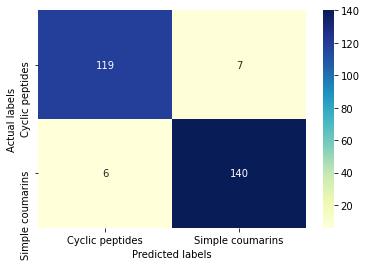

In [21]:
# Plot Confusion matrix
#import pandas as pd
#import matplotlib.pyplot as plt
#import seaborn as sns
#plt.figure(figsize = (80,80))
ax= plt.subplot()
df_cm = pd.DataFrame(conf_mat, columns=np.unique(y_test), index = np.unique(y_test))
df_cm.index.name = 'Actual labels'
df_cm.columns.name = 'Predicted labels'
sns.heatmap(df_cm, annot=True, ax = ax, cmap="YlGnBu", fmt='d')



## Select multi groups to do Random Forest

In [22]:
# Select major groups
from collections import Counter
lbs = Counter(y_label)
lbs = {k:v for k,v in sorted(lbs.items(), key=lambda item: item[1], reverse=True)}
print(list(lbs.values())[1:31])
select_lbs = list(lbs.keys())[1:31]
print(select_lbs)

# Define the data
select_index = []
for i in select_lbs:
    temp_index, = np.where(y_label==i)
    #print(temp_index)
    select_index += list(temp_index)
select_index.sort()
#print(select_index)

y_label_2_main = np.array(y_label[select_index])
print(y_label_2_main.shape)

X_embedding_2_lbs=X_embedding[select_index,:]
print(X_embedding_2_lbs.shape)



[557, 531, 394, 299, 279, 271, 259, 252, 247, 221, 221, 206, 182, 169, 167, 157, 153, 150, 145, 137, 129, 128, 127, 120, 113, 109, 109, 108, 103, 103]
['Cyclic peptides', 'Simple coumarins', 'Pyridine alkaloids', 'Dipeptides', 'Flavones', 'Flavonols', 'Oleanane triterpenoids', 'Carboline alkaloids', 'Triacylglycerols', 'Aminoacids', 'Glycerophosphocholines', 'Isoquinoline alkaloids', 'Cinnamic acids and derivatives', 'Linear peptides', 'Cholane steroids', 'Isoflavones', 'Carotenoids (C40', 'Chalcones', 'Iridoids monoterpenoids', 'Corynanthe type', 'Flavanones', 'Simple indole alkaloids', 'Pregnane steroids', 'Simple phenolic acids', 'Piperidine alkaloids', 'Tripeptides', 'Phenylalanine-derived alkaloids', 'N-acyl amines', 'Anthraquinones and anthrones', 'Furocoumarins']
(6146,)
(6146, 300)


In [23]:
### Perform Random Forest
# Split the dataset into the Training set and Test set
X_train, X_test, y_train, y_test = train_test_split(X_embedding_2_lbs, y_label_2_main, test_size = 0.25, random_state = 0)

# Feature Scaling
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

# Train Model
t0=time.process_time()
# Instantiate model with 10 decision trees
rf = RandomForestClassifier(n_estimators = 160, random_state = 0)
# Train the model on training data
rf.fit(X_train, y_train)
t1=time.process_time()-t0
y_pred = rf.predict(X_test)
print('Processing time: %.3f' % t1)

## Evaluate the model
print('Accuracy: %.3f' % accuracy_score(y_test, y_pred))
conf_mat = confusion_matrix(y_test,y_pred)

conf_mat = confusion_matrix(y_test,y_pred)
#print(conf_mat.shape)

Processing time: 13.072
Accuracy: 0.502


<AxesSubplot:xlabel='Predicted labels', ylabel='Actual labels'>

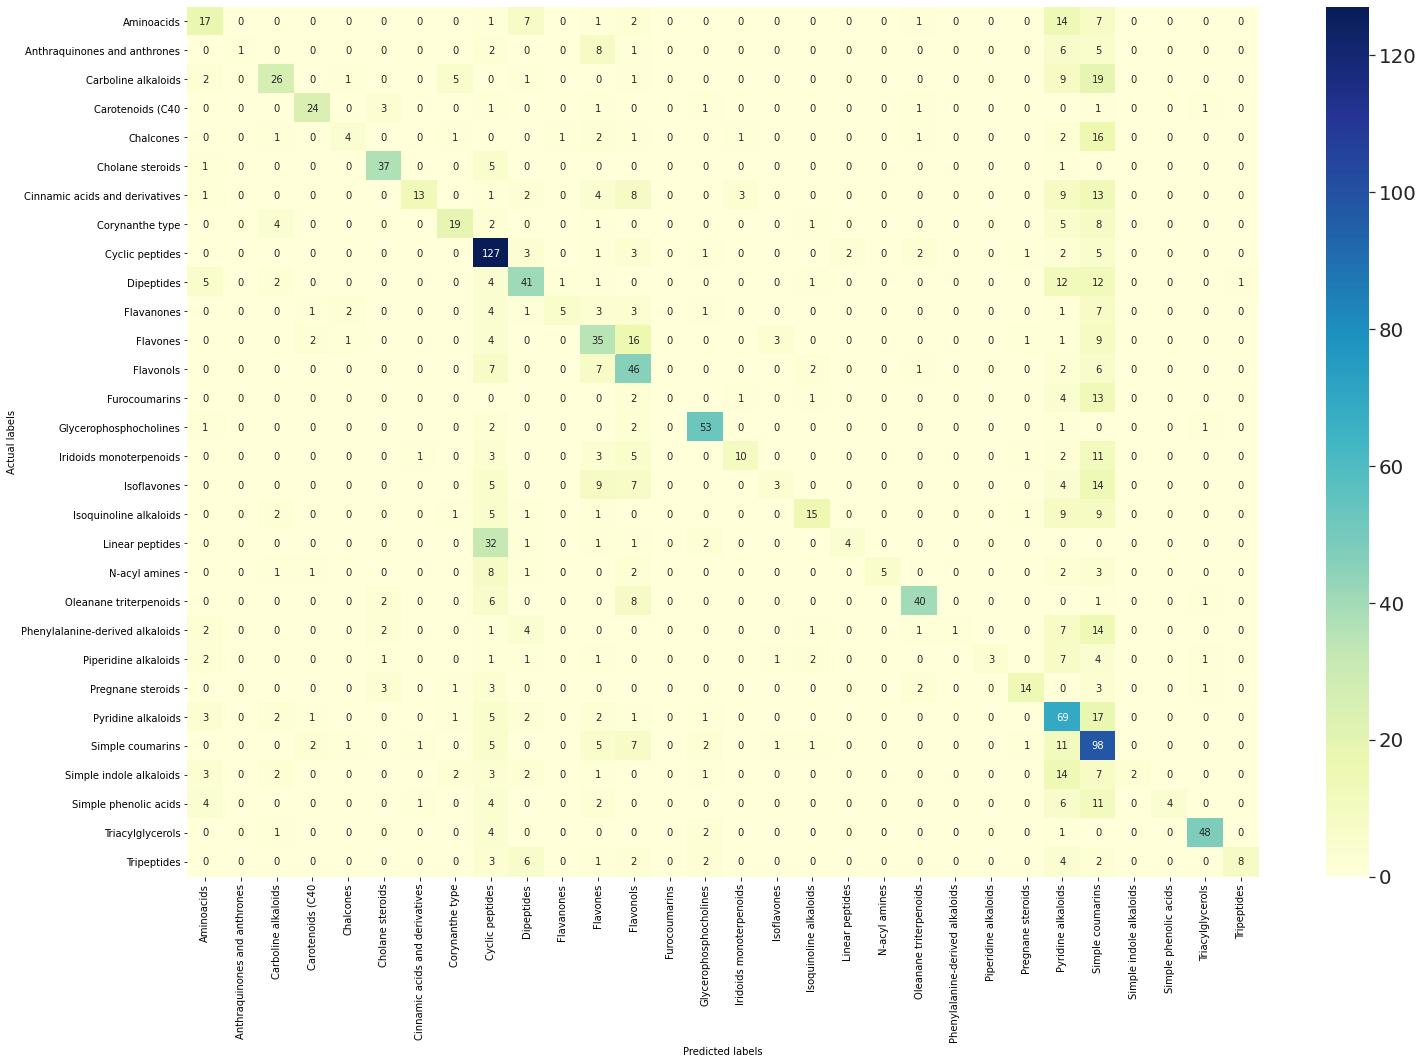

In [24]:
# Plot confusion matrix
plt.figure(figsize = (24,16))
ax= plt.subplot()
df_cm = pd.DataFrame(conf_mat, columns=np.unique(y_test), index = np.unique(y_test))
df_cm.index.name = 'Actual labels'
df_cm.columns.name = 'Predicted labels'
sns.set(font_scale=1.8)
sns.heatmap(df_cm, annot=True, ax = ax, cmap="YlGnBu", fmt='d',annot_kws={"size": 10})

